In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split , GridSearchCV ,cross_val_predict
from sklearn.preprocessing import StandardScaler  
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor

# I- Préparation de la base (voir R)

In [2]:
# Chargement des données

Gym = pd.read_csv("Donnees_projet.csv")

# Conversion des colonnes en catégories (équivalent à factor en R)
Gym['Gender'] = Gym['Gender'].astype('category')
Gym['Workout_Type'] = Gym['Workout_Type'].astype('category')
Gym['Workout_Frequency'] = Gym['Workout_Frequency (days/week)'].astype('category')
Gym['Experience_Level'] = Gym['Experience_Level'].astype('category')

# Renommage des colonnes pour simplifier l'accès
Gym['Session_Duration'] = Gym['Session_Duration (hours)']
Gym['Water_Intake'] = Gym['Water_Intake (liters)']

Gym["BMI"]=Gym["BMI"].map(lambda x: np.sqrt(x))

# Sélection des colonnes d'intérêt
Gym = Gym.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 13, 14, 15, 16, 17]]

# Affichage des premières lignes et résumé statistique
print(Gym.head())
print(Gym.describe(include='all'))

GymDum=pd.get_dummies(Gym[["Gender","Workout_Type","Experience_Level","Workout_Frequency"]])
GymDum = GymDum.drop(columns=["Workout_Type_Cardio","Experience_Level_1","Workout_Frequency_2"])
GymQuant= Gym.select_dtypes(include=['int64', 'float64'])

   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Calories_Burned Workout_Type  Fat_Percentage Experience_Level       BMI  \
0           1313.0         Yoga            12.6                3  5.495453   
1            883.0         HIIT            33.9                2  5.656854   
2            677.0       Cardio            33.4                2  4.970915   
3            532.0     Strength            28.8                1  4.290688   
4            556.0     Strength            29.2                1  3.793415   

  Workout_Frequency  Session_Duration  Water_Intake  
0                 4             

# II- Prévision des calories brûlées

Dans cette partie, nous avons pour objectif de prédire la quantitée de calories brûlées par rapport aux autres variables explicatives à notre disposition. Pour cela, nous allons tester plusieurs modèles et comparer leur efficacité. Pour la suite les variables explicatives qualitatives seront séparées en plusieurs variables par modalitées (par exemple Gender_female/ Gender_Male).

In [3]:
dfC=pd.concat([GymDum,GymQuant],axis=1)
dfC=dfC.drop(columns=["Calories_Burned"])
dfC.head()

,Gender_Female,Gender_Male,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga,Experience_Level_2,Experience_Level_3,Workout_Frequency_3,Workout_Frequency_4,Workout_Frequency_5,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Fat_Percentage,BMI,Session_Duration,Water_Intake
0,False,True,False,False,True,False,True,False,True,False,56,88.3,1.71,180,157,60,12.6,5.495453,1.69,3.5
1,True,False,True,False,False,True,False,False,True,False,46,74.9,1.53,179,151,66,33.9,5.656854,1.30,2.1
2,True,False,False,False,False,True,False,False,True,False,32,68.1,1.66,167,122,54,33.4,4.970915,1.11,2.3
3,False,True,False,True,False,False,False,True,False,False,25,53.2,1.70,190,164,56,28.8,4.290688,0.59,2.1
4,False,True,False,True,False,False,False,True,False,False,38,46.1,1.79,188,158,68,29.2,3.793415,0.64,2.8


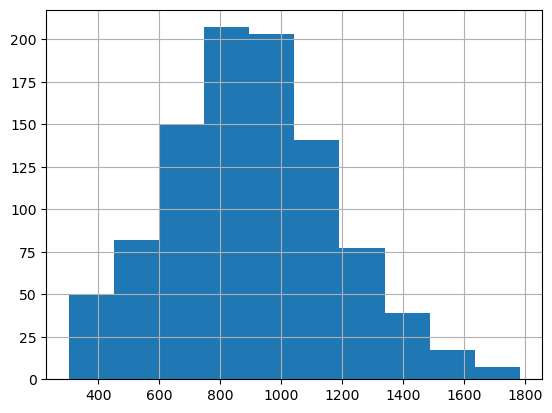

In [4]:
# variable à expliquer réelle
Y=Gym["Calories_Burned"]
Y.hist()
plt.show()

## 1) Séparation de la base en train/test

Avant de pouvoir réaliser nos différents modèle de prédiction, il est d'abord necessaire de séparer nos données en deux parties. La première partie correspond à 80% de la base complète. Elle permet d'entraîner un modèle sur les données qui lui sont fournies. La seconde partie est celle de test. Elle permettra d'appliquer notre modèle entraîné et de comparer les différentes méthodes entre elles.

In [5]:
X_train,X_test,Y_train,Y_test=train_test_split(dfC,Y,test_size=0.2,random_state=11)

In [6]:
# L'algorithme des réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.fit_transform(X_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(X_test)

## 2)Modèle linéaire 


On s'interesse d'abord aux modèles de type linéaire. Ceux-ci sont vastement utilisés pour leur simplicité et interpretabilité.

### a)Sans Pénalisation

La variable à expliquer étant quantitative, on utilise un modèle de regression linéaire.

In [7]:
# Régression linéaire sans pénalisation
regLin = LinearRegression()

# Entraîner sur tout le train, prédire sur le test
regLin.fit(Xr_train, Y_train)
# Prédiction sur le train
PrevLR_train = regLin.predict(Xr_train)
# Prédiction sur les données de test
PrevLR = regLin.predict(Xr_test)
# Evaluation
r2_test= r2_score(Y_test, PrevLR)
r2_train= r2_score(Y_train, PrevLR_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = Xr_train.shape[1]  # nombre de variables explicatives (prédicteurs)

Q2 = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test = mean_squared_error(Y_test, PrevLR)
mse_train = mean_squared_error(Y_train, PrevLR_train)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R²-ajusté sur test) = {Q2:.4f}")
print(f"MSE sur test = {mse_test:.4f}")
print(f"MSE sur train = {mse_train:.4f}")

R²-ajusté sur train = 0.9782
Q² (R²-ajusté sur test) = 0.9791
MSE sur test = 1594.5484
MSE sur train = 1521.0900


Le R2 classique étant fortement élevé, on en déduit que ce modèle à un biais très faible.  Cependant, sans pénalisation, les modèles linéaires ont tendance à faire de l'overfitting pour un nombre de paramètres important. On se retrouve donc avec des modèles trop complexes. Cela se traduit par un R2 ajusté plus faible bien que très satsifaisant. Parla suite, on utilisera principalement la MSE étant une valeure sure pour comparer nos méthodes.

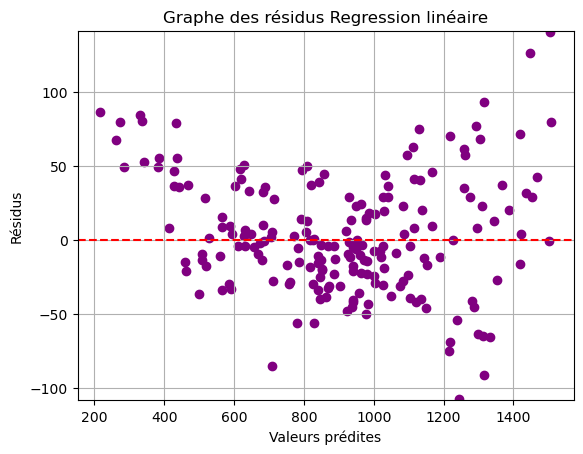

In [8]:
# Calcul des résidus
residusLR = Y_test - PrevLR

# Tracé du graphe des résidus
plt.scatter(PrevLR, residusLR, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Regression linéaire")

plt.ylim(min(residusLR) - 1, max(residusLR) + 1) 
plt.grid(True)
plt.show()

En affichant le graphique des résidus on remarque une forme "en banane" synonyme d'un modèle peu fiable. En effet, si le modèle était bon nous observerions une ligne droit proche de la ligne y=0. Cela confirme que le modèle de régression linéaire sans pénalisation ni sélection de variable n'est pas très efficace pour la prédiction des calories brulées.

### b) Pénalisation

Il est necessaire de trouver un équilibre entre le biais et la variance. En effet dans certaines situation, il est préférable de chosisir un modèle biaisé qui permet de réduire de manière importante la variance que de choisir un modèle à R2 élevé. A cet effet, nous allons utiliser différents critères de pénalisation sur les modèles trop complexes.

#### i.  Sans selection de variable (Ridge)

In [9]:
regRidge = Ridge()

# Grille de valeurs pour alpha (la pénalisation)
alphas = np.linspace(0.01, 10, 100)
param = {'alpha': alphas}
regRidge = GridSearchCV(regRidge, param, cv=5, n_jobs=-1)
regRidgeOpt = regRidge.fit(Xr_train, Y_train)

# paramètre optimal
alpha_opt = regRidgeOpt.best_params_["alpha"]
print("Meilleur paramètre = %s" % (regRidgeOpt.best_params_))

Meilleur paramètre = {'alpha': 0.9181818181818182}


In [10]:
regRidge = Ridge(alpha=alpha_opt)

# Entraîner sur tout le train, prédire sur le test
regRidge.fit(Xr_train,Y_train)
PrevRidge=regRidge.predict(Xr_test)
PrevRidge_train=regRidge.predict(Xr_train)

# Evaluation
r2_test= r2_score(Y_test, PrevRidge)
r2_train= r2_score(Y_train, PrevRidge_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = Xr_train.shape[1]  # nombre de variables explicatives (prédicteurs)

Q2 = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test = mean_squared_error(Y_test, PrevRidge)
mse_train = mean_squared_error(Y_train, PrevRidge_train)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R²-ajusté sur test) = {Q2:.4f}")
print(f"MSE sur test = {mse_test:.4f}")
print(f"MSE sur train = {mse_train:.4f}")

R²-ajusté sur train = 0.9782
Q² (R²-ajusté sur test) = 0.9792
MSE sur test = 1589.2928
MSE sur train = 1521.6404


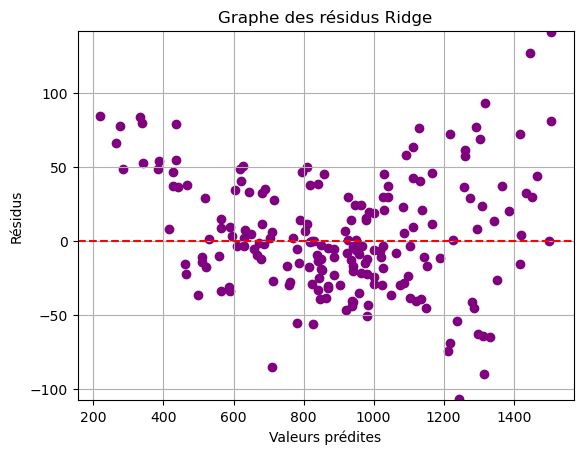

In [11]:
# Calcul des résidus
residusRidge = Y_test - PrevRidge

# Tracé du graphe des résidus
plt.scatter(PrevRidge, residusRidge, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Ridge")

plt.ylim(min(residusRidge) - 1, max(residusRidge) + 1) 
plt.grid(True)
plt.show()

#### ii. Avec sélection de variable (Cp/AIC/BIC et Lasso)

**LASSO**

Pour faire la pénalisation LASSO, On réalise d'abord une cross validation qui nous indique le lambda optimal. En python, la validation croisée est réalisée par GridSearchCV.

In [12]:
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":np.linspace(0.05, 5, 30) }]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, Y_train)
# paramètre optimal
alpha_opt = regLassOpt.best_params_["alpha"]
print("Meilleur paramètre = %s" % (regLassOpt.best_params_))

Meilleur paramètre = {'alpha': 1.2448275862068967}


Une fois le lambda réalisé on peut l'afficher sur les regularization paths (en R) pour voir les variables conservées par l'algorithme LASSO. En python, nous sommes obligé de reréaliser l'ajustement du modèle car GridSearchCV ne permet pas de garder les coefficients du modèles. Pour l'analyse nous avons donc besoin d'utiliser linear_model.Lasso directement.

Lasso conserve 11 variables et en supprime 9


Text(0.5, 1.0, 'Coefficients du modèle lasso')

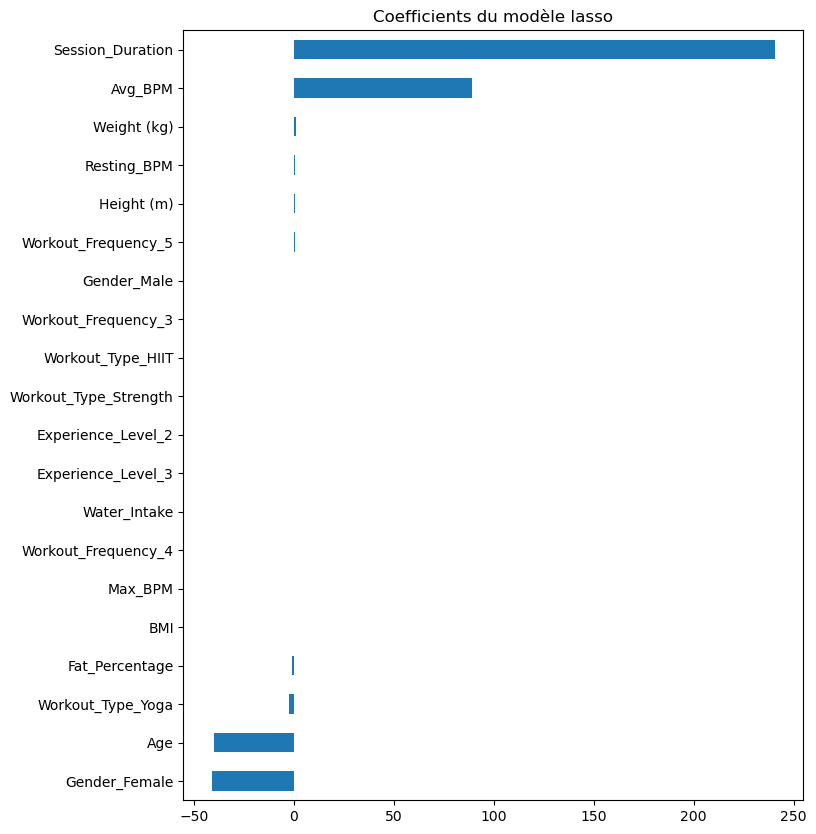

In [13]:
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])

# Entraîner sur tout le train, prédire sur le test
model_lasso=regLasso.fit(Xr_train,Y_train)
PrevLasso=regLasso.predict(Xr_test)
PrevLasso_train=regLassOpt.predict(Xr_train)

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

D'apres ce critère, les variables les plus interessantes pour prédire les carolies brûlées sont la durée de la session, le BPM moyen, le genre (Pour éviter les redondances, la modalitée princiaple gardée est le sexe féminin) et l'âge.

In [14]:
# Evaluation
r2_test= r2_score(Y_test, PrevLasso)
r2_train= r2_score(Y_train, PrevLasso_train)

n_train = len(Y_train)
n_test = len(Y_test)        # nombre d'observations
p = sum(coef != 0)  # nombre de variables explicatives (prédicteurs)

Q2 = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
R2_ajuste = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
mse_test = mean_squared_error(Y_test, PrevLasso)
mse_train = mean_squared_error(Y_train, PrevLasso_train)

print(f"R²-ajusté sur train = {R2_ajuste:.4f}")
print(f"Q² (R²-ajusté sur test) = {Q2:.4f}")
print(f"MSE sur test = {mse_test:.4f}")
print(f"MSE sur train = {mse_train:.4f}")

R²-ajusté sur train = 0.9780
Q² (R²-ajusté sur test) = 0.9803
MSE sur test = 1585.5329
MSE sur train = 1550.8393


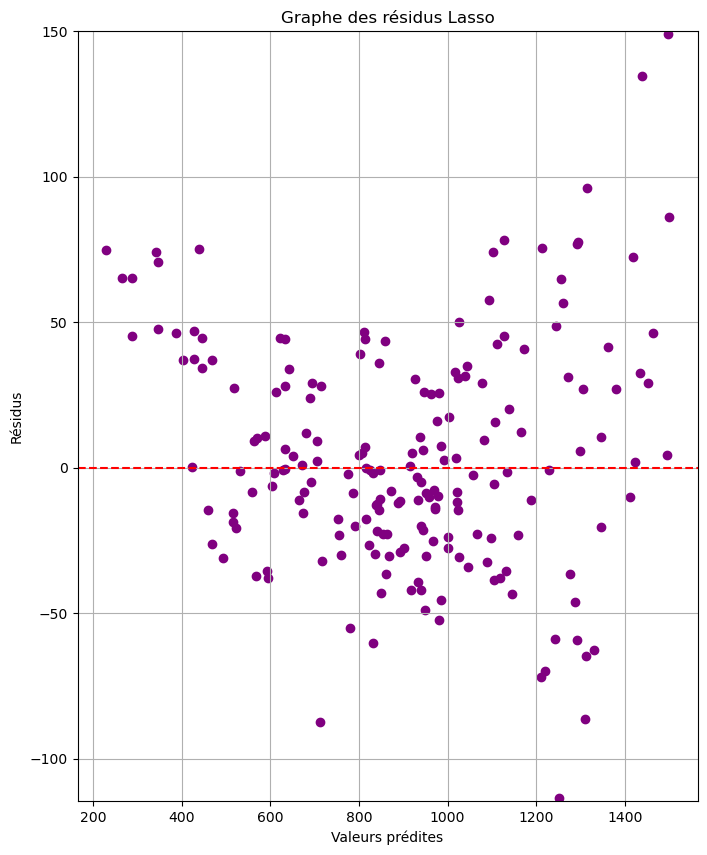

In [15]:
# Calcul des résidus
residusLasso = Y_test - PrevLasso

# Tracé du graphe des résidus
plt.scatter(PrevLasso, residusLasso, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale à y=0
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus Lasso")

plt.ylim(min(residusLasso) - 1, max(residusLasso) + 1) 
plt.grid(True)
plt.show()

Pour l'instant cette pénalisation semble pas avoir beaucoup d'effet. Bizarre que MSE diff de celle en R.

**Cp/AIC/BIC**

En python, il n'est pas possible d'utiliser ces méthodes de sélection de variable. En effet, sklearn ne propose pas directement de sélection par AIC. Nous nous refererons donc à notre notebook R pour cette méthode.

### c) Comparaison des modèles

Attention pour comparer les modèles il ne faut pas utiliser R2(echantillon train) mais Q2(sur échantillon test)!!

## 3) Support vector regression

In [16]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 0.5],
    "kernel": ["rbf"],
    "gamma": ["scale", 0.01, 0.02, 0.1, 1]
}

#param=[{"C":[0.4,0.5,0.6,0.8,1,1.4, 1.8]}]
svm= GridSearchCV(SVR(),param_grid,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xr_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.022674, Meilleur paramètre = {'C': 100, 'epsilon': 0.5, 'gamma': 0.02, 'kernel': 'rbf'}


In [17]:
# erreur de prévision sur le test
1-svmOpt.score(Xr_test,Y_test)

0.014357142366811182

In [18]:
print("Score Q^2 :", svmOpt.score(Xr_test, Y_test))

Score Q^2 : 0.9856428576331888


## 4) Arbre Optimal

In [19]:
# Optimisation de la profondeur de l'arbre pour un problème de régression
param = [{"max_depth": list(range(2, 10))}]
tree = GridSearchCV(DecisionTreeRegressor(), param, cv=10, n_jobs=-1)
treeOpt = tree.fit(Xr_train, Y_train)

# Affichage du meilleur score (R² ici) et du meilleur paramètre
print("Meilleur score (R²) = %f, Meilleur paramètre = %s" % (treeOpt.best_score_, treeOpt.best_params_))

Meilleur score (R²) = 0.919105, Meilleur paramètre = {'max_depth': 9}


In [20]:
# Estimation de l'erreur de prévision
1-treeOpt.score(Xr_test,Y_test)

0.06714653888978495

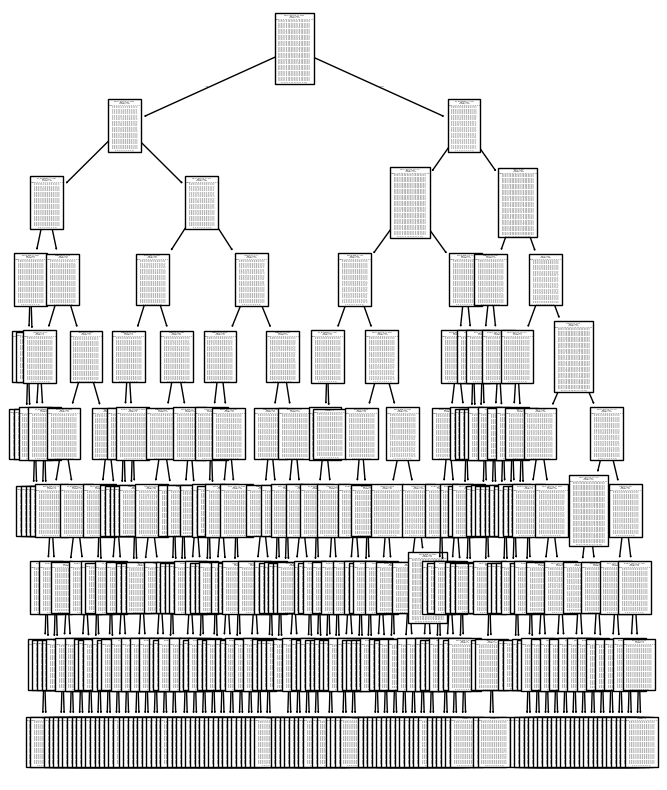

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

treeG=DecisionTreeClassifier(max_depth=treeOpt.best_params_['max_depth'])
treeG.fit(Xr_train,Y_train)
plot_tree(treeG,feature_names=dfC.columns.tolist());
plt.show()

## 5) Forêt aléatoire

## 6) Boosting

## 7) Réseaux de neurones

# III- Prévision du niveau d'experience

## 1) Séparation de la base en train/test

## 2) Modèle linéaire

### i. Regression logistique

### ii. LSVM

## 3)SVR/SVM

## 4) Arbre optimal CART

## 5) Forêt aléatoire

## 6) Boosting

## 7) Réseaux de neuronne